In [ ]:
# In this script, we developed a simple momentum strategy
# where we believe stock price trends will persist in the short term.
# We generate signals according to when the price trend is turning upward / downward

In [30]:
import numpy as np
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt
import yfinance as yf

In [31]:
symbols_list = ["AAPL", "AMZN", "FB", "WMT"]
start = dt.datetime(2010,8,1)
end = dt.datetime(2020,7,31)
data = yf.download(symbols_list, start=start, end=end)

[*********************100%***********************]  4 of 4 completed


In [32]:
data.head()

Adj Close                                Close                  \
                AAPL        AMZN  FB        WMT      AAPL        AMZN  FB   
Date                                                                        
2010-08-02  8.081243  120.070000 NaN  39.842934  9.351786  120.070000 NaN   
2010-08-03  8.083712  122.419998 NaN  39.749924  9.354643  122.419998 NaN   
2010-08-04  8.116117  127.580002 NaN  39.990189  9.392143  127.580002 NaN   
2010-08-05  8.076613  127.830002 NaN  40.005688  9.346429  127.830002 NaN   
2010-08-06  8.026928  128.320007 NaN  40.137444  9.288929  128.320007 NaN   

                           High              ... Low                 Open  \
                  WMT      AAPL        AMZN  ...  FB        WMT      AAPL   
Date                                         ...                            
2010-08-02  51.410000  9.378214  120.379997  ... NaN  50.950001  9.301429   
2010-08-03  51.290001  9.402143  122.870003  ... NaN  51.029999  9.321786   
2010-08-04  51.599998  9.438571  128.470001  ... NaN  51.009998  9.387143   
2010-08-05  51.619999  9.399285  128.000000  ... NaN  51.220001  9.347500   
2010-08-06  51.790001  9.338928  128.399994  ... NaN  51.110001  9.277857   

                                          Volume                         
                  AMZN  FB        WMT       AAPL     AMZN  FB       WMT  
Date                                                                     
2010-08-02  119.150002 NaN  51.549999  428055600  5443700 NaN  13861000  
2010-08-03  120.000000 NaN  51.250000  417653600  5953800 NaN  10668600  
2010-08-04  123.059998 NaN  51.040001  420375200  9270800 NaN   8068900  
2010-08-05  126.769997 NaN  51.639999  289097200  4282300 NaN   7439000  
2010-08-06  126.720001 NaN  51.419998  444897600  5065200 NaN   8270300  

[5 rows x 24 columns]

In [33]:
maindata = data["Adj Close"]
maindata.head()

,AAPL,AMZN,FB,WMT
Date,,,,
2010-08-02,8.081243,120.070000,NaN,39.842934
2010-08-03,8.083712,122.419998,NaN,39.749924
2010-08-04,8.116117,127.580002,NaN,39.990189
2010-08-05,8.076613,127.830002,NaN,40.005688
2010-08-06,8.026928,128.320007,NaN,40.137444


Text(0, 0.5, 'price in $')

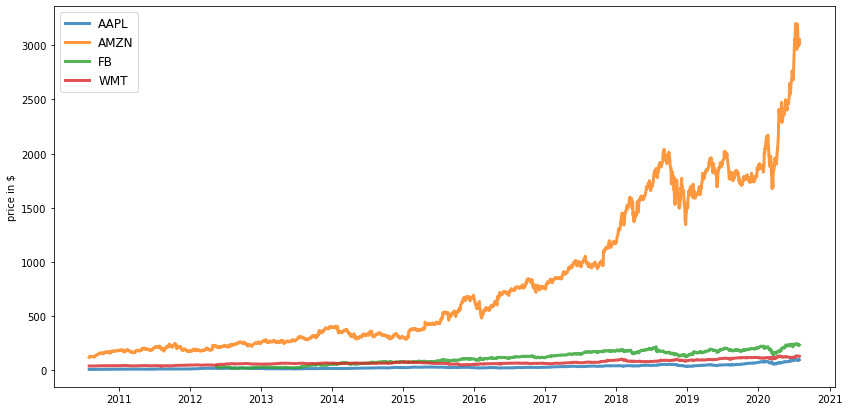

In [34]:
plt.figure(figsize=(14, 7))
for c in maindata.columns.values:
    plt.plot(maindata.index, maindata[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

In [41]:
maindata[['AMZN']].head()

,AMZN
Date,
2010-08-02,120.070000
2010-08-03,122.419998
2010-08-04,127.580002
2010-08-05,127.830002
2010-08-06,128.320007


In [36]:
def momentum_strat(df, short_window, long_window, ticker):

    # Create a new DataFrame titled 'signals' and set the signal values to 0
    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0.0

    # Calculate the short term moving average based on the window provided
    signals['short_mavg'] = df[ticker].rolling(window=short_window, min_periods=1).mean()

    # Calculate the long term moving average based on the window provided
    signals['long_mavg'] = df[ticker].rolling(window=long_window, min_periods=1).mean()

    # Create signals. When the short run MA exceeds the long run MA, value=1, when short run MA below long run MA, value=0.
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders based on the crossover points (difference in intra-day signals)
    # ie. when signals change from 0 to 1 (momentum change), position will be 1 signifying 'buy';
    # when signals change from 1 to 0 (momentum change), position will be -1 signifying 'sell';
    # when no change in signal, position will be 0, do nothing and keep current position
    signals['positions'] = signals['signal'].diff()
    
    
    # Plot the adjusted closing price
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(df[ticker], color='m', lw=2.)

    # Plot the short and long moving averages
    signals[['short_mavg', 'long_mavg']].plot(ax=ax, lw=2.)

    # Plot the buy signals (with arrows up in green triangle)
    ax.plot(signals.loc[signals.positions == 1.0].index, signals.short_mavg[signals.positions == 1.0], '^', markersize=10, color='g')
         
    # Plot the sell signals (with arrows down in red triangle)
    ax.plot(signals.loc[signals.positions == -1.0].index, signals.short_mavg[signals.positions == -1.0], 'v', markersize=10, color='r')
    
    plt.show()
    
    # Combining the original dataframe with the signals dataframe to calculate returns over each period between a change in position
    combined_df= pd.merge(df, signals[(signals['positions'] == 1.0) | (signals['positions'] == -1.0)], on=['Date'])
    combined_df[ticker + ' returns'] = combined_df[ticker].pct_change()
    
    cum_returns = combined_df[ticker + ' returns'].sum() * 100
    print("The cumulative returns from the momentum trading strategy is", cum_returns, "%.")
        
    # Show dataframe of buy and sell dates
    return combined_df

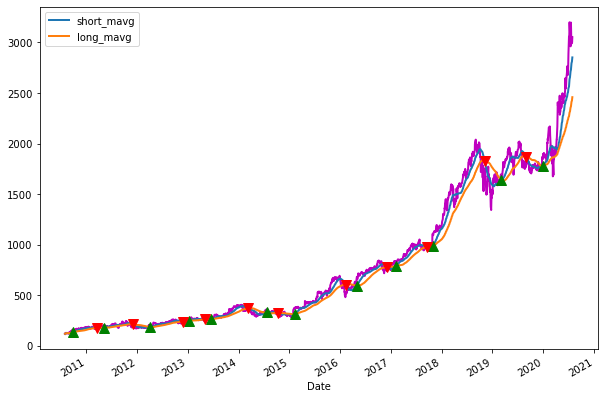

The cumulative returns from the momentum trading strategy is 281.63209646732025 %.


,AAPL,AMZN,FB,WMT,signal,short_mavg,long_mavg,positions,AMZN returns
Date,,,,,,,,,
2010-09-28,8.853107,159.699997,NaN,41.953712,1.0,136.125751,135.734147,1.0,NaN
2011-03-18,10.205176,161.820007,NaN,40.665619,0.0,175.432000,175.756799,-1.0,0.013275
2011-05-06,10.698661,197.600006,NaN,43.428230,1.0,180.281501,180.065000,1.0,0.221110
2011-12-07,12.008138,195.320007,NaN,47.117397,0.0,212.459500,212.910100,-1.0,-0.011538
2012-04-05,19.556702,194.389999,NaN,49.183422,1.0,187.975749,187.794799,1.0,-0.004761
2012-11-27,18.207819,243.399994,26.150000,57.029869,0.0,238.923751,239.050300,-1.0,0.252122
2013-01-08,16.356150,266.380005,29.059999,56.595085,1.0,247.328750,246.730801,1.0,0.094413
2013-05-02,13.952632,252.550003,28.969999,65.156715,0.0,262.882750,262.959700,-1.0,-0.051918
2013-06-17,13.618771,278.059998,24.020000,62.615154,1.0,265.352749,265.249300,1.0,0.101010


In [37]:
# Looking at Amazon
momentum_strat(maindata, short_window=40, long_window=100, ticker='AMZN')

In [38]:
# From the plot, we can see the crossover points, 
# where the short-run MA crosses the long-run MA line, 
# a buy or sell signal is generated. The cumulative returns from the strategy was 281% over 10 years. 
# The momentum strategy works well due to the AMZN stock having a strong upward performance over the period.

#However, the caveat is that transaction costs were not considered 
# and historical performance is not indicative of future performance.